In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
import time

/home/linhdb/miniconda3/envs/torch_boost/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir.replace('images', 'masks')) if '_mask.png' in f]
        
        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir.replace('images', 'masks'), self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [3]:
class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.validation_step_outputs = []
        self.test_step_outputs = []
        
        self.num_classes = 2
        
        self.label2id = {0: 'background', 1: 'receipt'}
        self.id2label = {v:k for k,v in self.label2id.items()}

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        self.validation_step_outputs.append(loss)
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        metrics = self.val_mean_iou.compute(
            num_labels=self.num_classes, 
            ignore_index=255, 
            reduce_labels=False,
        )
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou": val_mean_iou, "val_mean_accuracy": val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics

    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]

        self.test_step_outputs.append(loss)
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def on_test_epoch_end(self):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack(self.test_step_outputs).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl
    

        

In [4]:
dataset_location = "data/mcocr"
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset(f"{dataset_location}/images/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset_location}/images/val/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset_location}/images/test/", feature_extractor)

batch_size = 32
num_workers = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

/home/linhdb/miniconda3/envs/torch_boost/lib/python3.8/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_9441/2370556508.py:26: FutureWarning: load_metric is deprecated and will be removed in the next major version 

In [5]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.00, 
    patience=10, 
    verbose=False, 
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    accelerator='gpu',
    devices = 1, 
    log_every_n_steps = 20,
    callbacks=[checkpoint_callback],
    max_epochs=5,
    val_check_interval=len(train_dataloader),
    profiler="simple",
    precision="16"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
start = time.time()
trainer.fit(segformer_finetuner)
end = time.time()
elapsed = end - start
print(f"Time elapsed {elapsed/60:.2f} min")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-----------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 37/37 [02:35<00:00,  4.21s/it, v_num=0]          

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 37/37 [02:35<00:00,  4.21s/it, v_num=0]


FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -       

Time elapsed 15.59 min


In [7]:
# 5 epochs ~ 18-20mins

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [7]:
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /mnt/d/SUN/server/pytorch_train_enhance/lightning_logs/version_0/checkpoints/epoch=4-step=185.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /mnt/d/SUN/server/pytorch_train_enhance/lightning_logs/version_0/checkpoints/epoch=4-step=185.ckpt


Testing DataLoader 0: 100%|██████████| 13/13 [00:38<00:00,  2.95s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1331779658794403     │
│    test_mean_accuracy     │     0.958668652792443     │
│       test_mean_iou       │    0.9202669380523965     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -      

In [8]:
Image.open('/mnt/d/SUN/server/pytorch_train_enhance/data/Balloons-mask-semantic/test/15290896925_884ab33fd3_k_jpg.rf.35191853c8f633667636765fb640425d_mask.png').size

(1356, 2048)

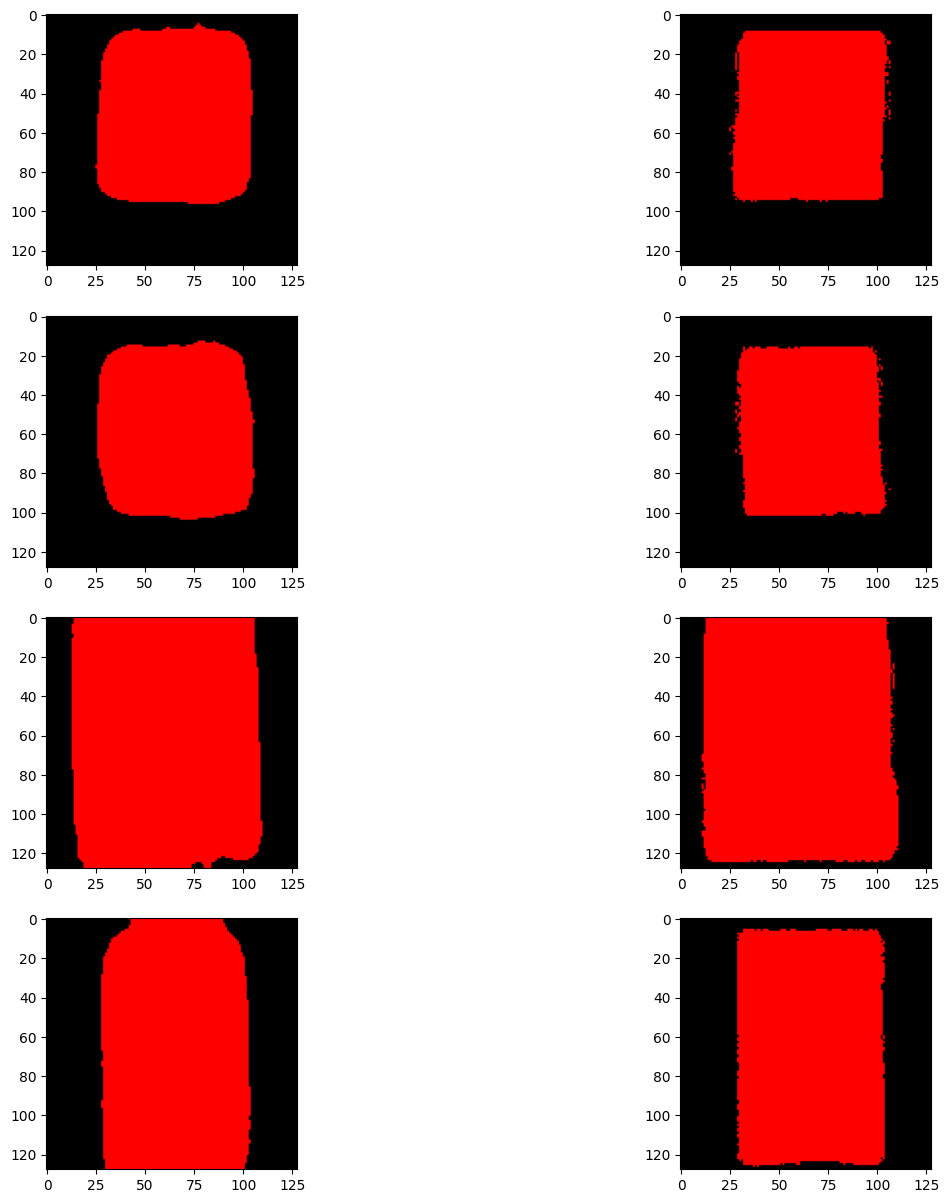

In [9]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)
        
    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits, 
        size=masks.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))


In [10]:
#Predict on a test image and overlay the mask on the original image
test_idx = 2
input_image_file = os.path.join(test_dataset.root_dir, test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, masks = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images, masks)
    
loss, logits = outputs[0], outputs[1]

upsampled_logits = nn.functional.interpolate(
    logits, 
    size=masks.shape[-2:], 
    mode="bilinear", 
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(masks))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)